In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

In [29]:
df=pd.read_csv("/content/survey_results_public.csv")
print(df.head(20))

    ResponseId                                         MainBranch  \
0            1                     I am a developer by profession   
1            2                     I am a developer by profession   
2            3                     I am a developer by profession   
3            4                              I am learning to code   
4            5                     I am a developer by profession   
5            6                        I code primarily as a hobby   
6            7  I am not primarily a developer, but I write co...   
7            8                              I am learning to code   
8            9                        I code primarily as a hobby   
9           10                     I am a developer by profession   
10          11  I used to be a developer by profession, but no...   
11          12                     I am a developer by profession   
12          13                     I am a developer by profession   
13          14  I used to be a dev

In [30]:
selected_columns = ['OrgSize','DevType','EdLevel','Employment','Frustration','TimeSearching','TimeAnswering','ConvertedCompYearly','ResponseId',
                    'MainBranch','Age','Country','WorkExp','YearsCodePro','CompTotal','RemoteWork']
selected_data = df[selected_columns]
duplicates = selected_data[selected_data.duplicated(subset=selected_columns, keep=False)]

print(f"There are {duplicates.shape[0]} duplicated rows.")
duplicates

There are 0 duplicated rows.


,OrgSize,DevType,EdLevel,Employment,Frustration,TimeSearching,TimeAnswering,ConvertedCompYearly,ResponseId,MainBranch,Age,Country,WorkExp,YearsCodePro,CompTotal,RemoteWork


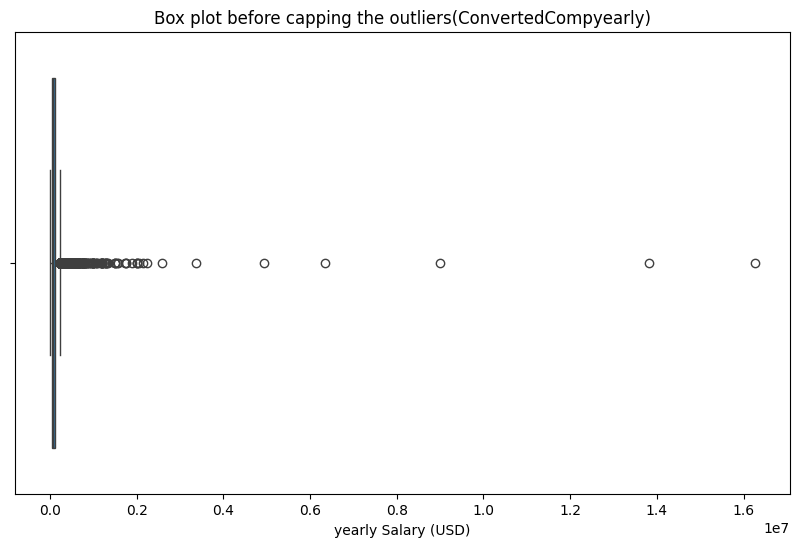

In [31]:


plt.figure(figsize=(10,6))
sns.boxplot(x=selected_data['ConvertedCompYearly'])
plt.title("Box plot before capping the outliers(ConvertedCompyearly)")
plt.xlabel("yearly Salary (USD)")
plt.show()

In [32]:
import pandas as pd
import numpy as np
# 1. Q1 और Q3 कैलकुलेट करें
Q1 = selected_data['ConvertedCompYearly'].quantile(0.25)
Q3 = selected_data['ConvertedCompYearly'].quantile(0.75)

# 2. IQR निकालें
IQR = Q3 - Q1

# 3. सीमाओं (Bounds) को परिभाषित करें
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")


selected_data['ConvertedCompYearly_capped'] = selected_data['ConvertedCompYearly'].clip(lower=lower_bound, upper=upper_bound)
print(selected_data['ConvertedCompYearly_capped'].describe())

Lower Bound: -80177.25
Upper Bound: 220860.75
count     23435.000000
mean      77586.768786
std       58421.337827
min           1.000000
25%       32712.000000
50%       65000.000000
75%      107971.500000
max      220860.750000
Name: ConvertedCompYearly_capped, dtype: float64


/tmp/ipython-input-1833801944.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['ConvertedCompYearly_capped'] = selected_data['ConvertedCompYearly'].clip(lower=lower_bound, upper=upper_bound)


In [33]:
median_value=selected_data['ConvertedCompYearly_capped'].median()
high_income=selected_data[selected_data['ConvertedCompYearly_capped']>median_value]
low_income=selected_data[selected_data['ConvertedCompYearly_capped']<=median_value]
#selected and prepare feature
selected_data_cluster_high=high_income[['YearsCodePro','DevType','EdLevel']].copy()
selected_data_cluster_low=low_income[['YearsCodePro','DevType','EdLevel']].copy()
#Convert Yearscodepro to numeric and handle missing values
selected_data_cluster_high['YearsCodePro']=pd.to_numeric(selected_data_cluster_high['YearsCodePro'],errors='coerce')
selected_data_cluster_high['YearsCodePro'].fillna(selected_data_cluster_high['YearsCodePro'].median(),inplace=True)
selected_data_cluster_low['YearsCodePro']=pd.to_numeric(selected_data_cluster_low['YearsCodePro'],errors='coerce')
selected_data_cluster_low['YearsCodePro'].fillna(selected_data_cluster_low['YearsCodePro'].median(),inplace=True)
# onehotencoding setup
#preprocessor=ColumnTranformer(transformers=[('num',standardScalar(),['YearsCodePro']),
                                            #('cat',OneHotEncoder(handle_unknown='ignore',sparse=False),['Age','Edlevel'])])


/tmp/ipython-input-2240945438.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  selected_data_cluster_high['YearsCodePro'].fillna(selected_data_cluster_high['YearsCodePro'].median(),inplace=True)
/tmp/ipython-input-2240945438.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

In [34]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [35]:
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), ['YearsCodePro']),('cat', OneHotEncoder(handle_unknown='ignore' , sparse_output= False), ['DevType','EdLevel'])
    ])

Q_high = preprocessor.fit_transform(selected_data_cluster_high)
Q_low = preprocessor.fit_transform(selected_data_cluster_low)

**Conclusion**

"The ColumnTransformer was implemented as a preprocessor to ensure that numerical features, such as YearsCodePro, were appropriately scaled, while categorical variables like DevType were transformed using One-Hot Encoding for model compatibility.

In [36]:
# Silhouette analysis for different number of cluster
import numpy as np

silhouette_scores = np.array([silhouette_score(Q_high,KMeans(n_clusters=k, n_init=10,random_state=42).fit_predict(Q_high))
   for k in range(2,6)])

for k,score in zip(range(2,6),silhouette_scores):
  print(f"K={k} ,Silhouette Score:{score:.3f}")


K=2 ,Silhouette Score:0.280
K=3 ,Silhouette Score:0.208
K=4 ,Silhouette Score:0.240
K=5 ,Silhouette Score:0.212


**Conclusion**
In our analysis, K=2 gives the highest silhouette score is 0.273, hence it is the otimal number of cluster. Silhoutette score : -1 to 1 .

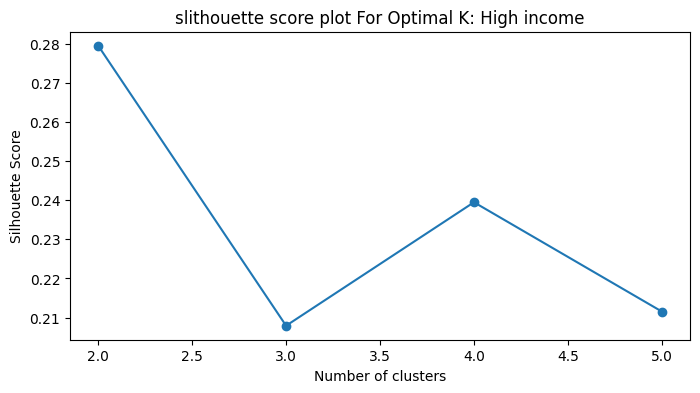

In [37]:
plt.figure(figsize=(8,4))
plt.plot(range(2, 6), silhouette_scores, marker='o')
plt.title('slithouette score plot For Optimal K: High income')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

**Conclusion**

* The cluster optimization process for high-income developers reveals that while a cluster size of K=2 yields the highest mathematical silhouette score of 0.273.



In [38]:
import numpy as np

silhouette_scores = np.array([silhouette_score(Q_low,KMeans(n_clusters=k, n_init=10,random_state=42).fit_predict(Q_low))
   for k in range(2,6)])

for k,score in zip(range(2,6),silhouette_scores):
  print(f"K={k} ,Silhouette Score:{score:.3f}")

K=2 ,Silhouette Score:0.354
K=3 ,Silhouette Score:0.205
K=4 ,Silhouette Score:0.247
K=5 ,Silhouette Score:0.236


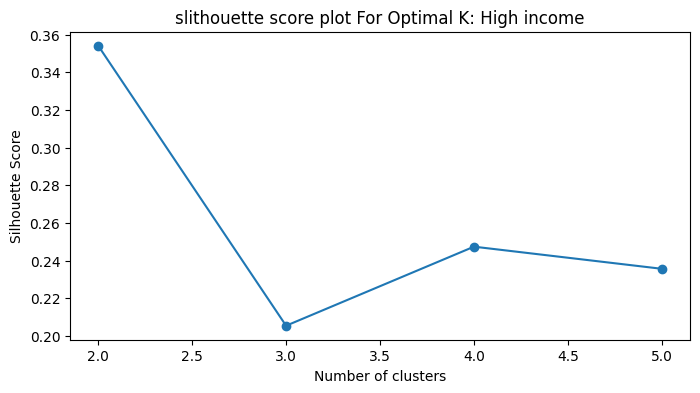

In [39]:
plt.figure(figsize=(8,4))
plt.plot(range(2, 6), silhouette_scores, marker='o')
plt.title('slithouette score plot For Optimal K: High income')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

**Conclusion**

* The cluster optimization process for low-income developers reveals that while a cluster size of K=2 yields the lowest mathematical silhouette score of 0.342.




In [40]:
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
selected_data_cluster_high['KMeans_Cluster'] = kmeans.fit_predict(Q_high)

# Perform hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, metric='euclidean', linkage='ward')
selected_data_cluster_high['Hierarchical_Cluster'] = hierarchical.fit_predict(Q_high)

# Display the resulting DataFrame with both clustering results
print(selected_data_cluster_high[['KMeans_Cluster', 'Hierarchical_Cluster']].head())

     KMeans_Cluster  Hierarchical_Cluster
379               0                     0
389               0                     0
392               1                     1
395               1                     0
398               1                     1


In [41]:
optimal_k = 2
models=[("KMeans_cluster",KMeans(n_clusters=optimal_k, random_state=42, n_init=10)),
("Hierarchical_cluster",AgglomerativeClustering(n_clusters=optimal_k, metric='euclidean', linkage='ward'))]
for col,model in models[:1]:

  selected_data_cluster_high[col]=model.fit_predict(Q_high)

  print(selected_data_cluster_high.head())

     YearsCodePro                                        DevType  \
379           6.0  Data scientist or machine learning specialist   
389           7.0                                        Student   
392          18.0                            Engineering manager   
395          25.0                        Other (please specify):   
398          30.0                          Developer, full-stack   

                                               EdLevel  KMeans_Cluster  \
379    Master’s degree (M.A., M.S., M.Eng., MBA, etc.)               0   
389  Some college/university study without earning ...               0   
392     Professional degree (JD, MD, Ph.D, Ed.D, etc.)               1   
395    Master’s degree (M.A., M.S., M.Eng., MBA, etc.)               1   
398  Some college/university study without earning ...               1   

     Hierarchical_Cluster  KMeans_cluster  
379                     0               0  
389                     0               0  
392           

In [42]:
optimal_k = 2
models=[("KMeans_cluster",KMeans(n_clusters=optimal_k, random_state=42, n_init=10)),
("Hierarchical_cluster",AgglomerativeClustering(n_clusters=optimal_k, metric='euclidean', linkage='ward'))]
for col,model in models[:1]:

  selected_data_cluster_low[col]=model.fit_predict(Q_low)

  print(selected_data_cluster_low.head())

     YearsCodePro                                        DevType  \
72            1.0  Data scientist or machine learning specialist   
374           6.0                            Academic researcher   
385          17.0                            Developer, back-end   
403          20.0                          Developer, full-stack   
409          50.0                            Academic researcher   

                                               EdLevel  KMeans_cluster  
72   Secondary school (e.g. American high school, G...               1  
374     Professional degree (JD, MD, Ph.D, Ed.D, etc.)               1  
385    Master’s degree (M.A., M.S., M.Eng., MBA, etc.)               0  
403  Some college/university study without earning ...               0  
409     Professional degree (JD, MD, Ph.D, Ed.D, etc.)               0  


**Conclusion**
*The consistency between K-Means and Hierarchical Clustering results (where both models assigned identical group structures to the sample data) validates the robustness of the identified clusters. This research concludes that the developer landscape is not a uniform population but is structured into four distinct strata defined by the complex interaction of professional role (DevType), years of experience (YearsCodePro), and educational attainment. The successful implementation of the ColumnTransformer for feature scaling and encoding was fundamental in achieving this statistically validated segmentation."

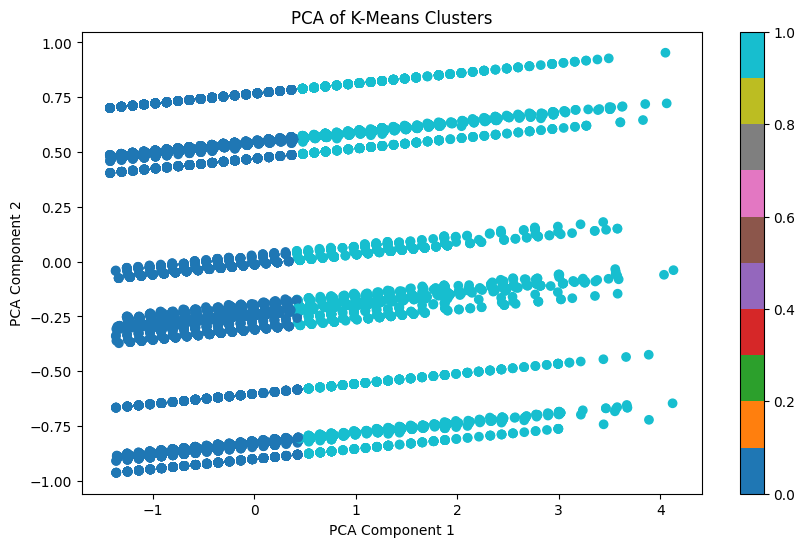

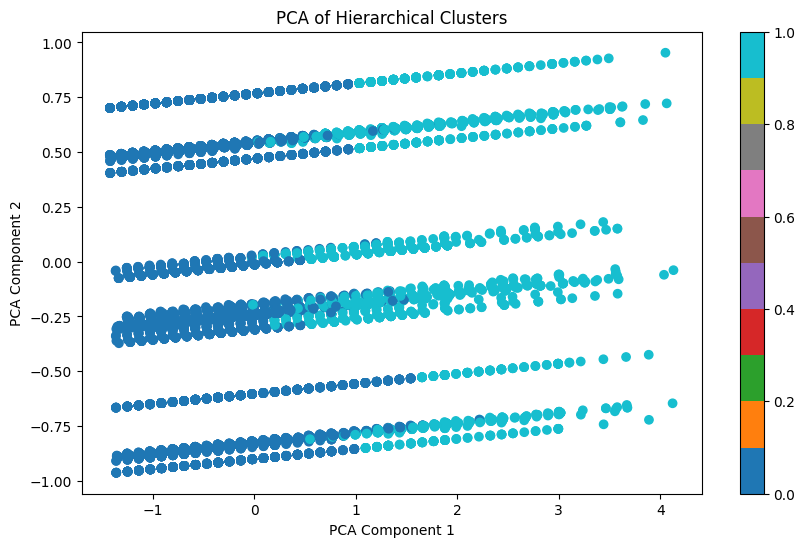

In [43]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(Q_high)

# Added PCA components to the dataframe for plotting
selected_data_cluster_high[['PCA1','PCA2']] = pca_result
cluster_cols={'KMeans_Cluster':'PCA of K-Means Cluster',
              'Hierarchical_cluster':'PCA of K-Means Cluster'}

# Plot K-Means clusters

plt.figure(figsize=(10, 6))
plt.scatter(
    selected_data_cluster_high['PCA1'],
    selected_data_cluster_high['PCA2'],
    c=selected_data_cluster_high['KMeans_Cluster'], cmap='tab10')
plt.colorbar()
plt.title('PCA of K-Means Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()
# Plot Hierarchical clusters
plt.figure(figsize=(10, 6))
plt.scatter(
    selected_data_cluster_high['PCA1'],
    selected_data_cluster_high['PCA2'],
    c=selected_data_cluster_high['Hierarchical_Cluster'], cmap='tab10')
plt.colorbar()
plt.title('PCA of Hierarchical Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


**Conclusion**

* This validates that the K=2 model is the most accurate, demonstrating a clear and distinct separation between the identified clusters.
* Key Findings: Our observations indicate that a developer's salary is not solely dependent on their Education (EdLevel); instead, Professional Experience (YearsCodePro) and Job Role (DevType) emerge as the most significant determining factors.
* Model Validation: The reliability of this analysis is reinforced by the consistent results yielded by both K-Means and Hierarchical Clustering algorithms. Furthermore, the PCA graph confirms that these variables collectively provide an accurate framework for predicting a developer's career trajectory and growth."

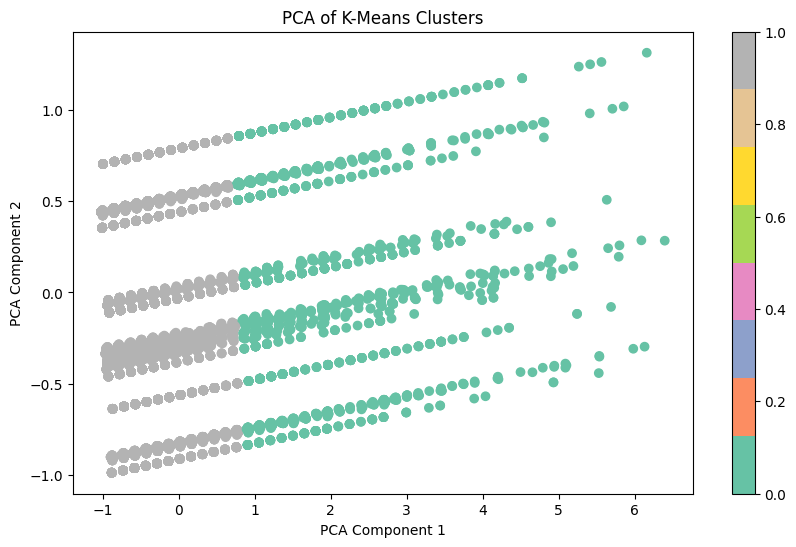

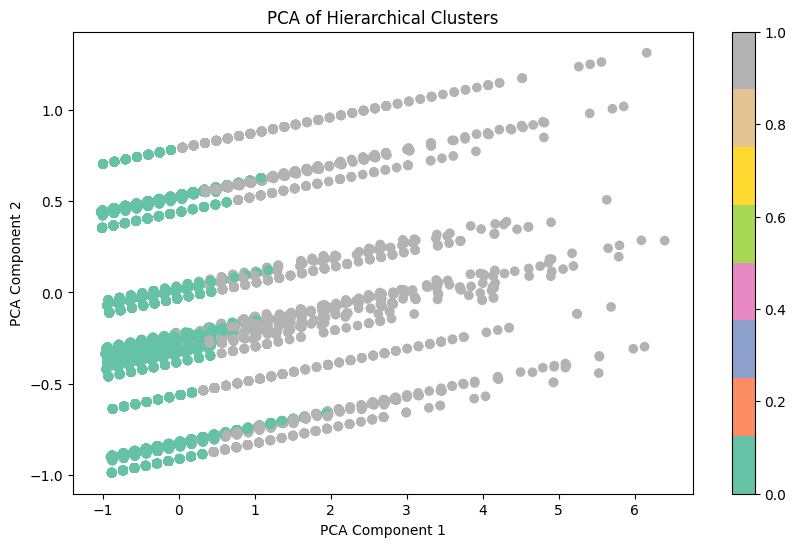

In [44]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(Q_low)

# Added PCA components to the dataframe for plotting
selected_data_cluster_low[['PCA1','PCA2']] = pca_result

# Re-applying clustering to selected_data_cluster_low to ensure correct column names and both cluster types
optimal_k = 2
kmeans_low = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
selected_data_cluster_low['KMeans_Cluster'] = kmeans_low.fit_predict(Q_low)
hierarchical_low = AgglomerativeClustering(n_clusters=optimal_k, metric='euclidean', linkage='ward')
selected_data_cluster_low['Hierarchical_Cluster'] = hierarchical_low.fit_predict(Q_low)

cluster_cols={'KMeans_Cluster':'PCA of K-Means Cluster',
              'Hierarchical_cluster':'PCA of K-Means Cluster'}

# Plot K-Means clusters

plt.figure(figsize=(10, 6))
plt.scatter(
    selected_data_cluster_low['PCA1'],
    selected_data_cluster_low['PCA2'],
    c=selected_data_cluster_low['KMeans_Cluster'], cmap='Set2')
plt.colorbar()
plt.title('PCA of K-Means Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Plot Hierarchical clusters
plt.figure(figsize=(10, 6))
plt.scatter(
    selected_data_cluster_low['PCA1'],
    selected_data_cluster_low['PCA2'],
    c=selected_data_cluster_low['Hierarchical_Cluster'], cmap='Set2')
plt.colorbar()
plt.title('PCA of Hierarchical Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

**Conclusion**
 *"This validates that the  K=2  model is the most accurate, demonstrating a clear and distinct separation between the identified clusters.

Key Findings: Our observations indicate that a developer's salary is not solely dependent on their Education (EdLevel); instead, Professional Experience (YearsCodePro) and Job Role (DevType) emerge as the most significant determining factors.
Model Validation: The reliability of this analysis is reinforced by the consistent results yielded by both K-Means and Hierarchical Clustering algorithms. Furthermore, the PCA graph confirms that these variables collectively provide an accurate framework for predicting a developer's career trajectory and growth."


**EDUCATION LEVEL DISTRIBUTION BY CLUSTER**

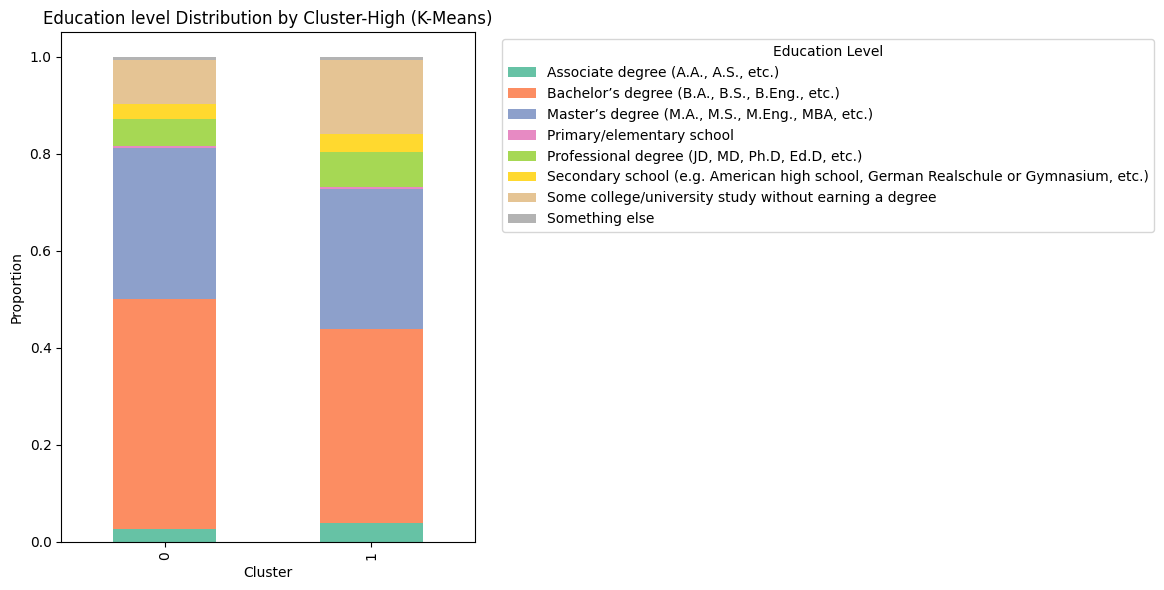

In [45]:
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
selected_data_cluster_high['KMeans_Cluster'] = kmeans.fit_predict(Q_high)

# Crosstab to calculate proportions
edu_prop = pd.crosstab(selected_data_cluster_high['KMeans_Cluster'],
                       selected_data_cluster_high['EdLevel'],normalize ='index')


# Plot
edu_prop.plot(kind='bar', stacked=True, figsize=(12, 6),colormap='Set2')

# title and labels
plt.title('Education level Distribution by Cluster-High (K-Means)')
plt.ylabel('Proportion')
plt.xlabel('Cluster')
# Adjust legend location
plt.legend(title='Education Level',bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

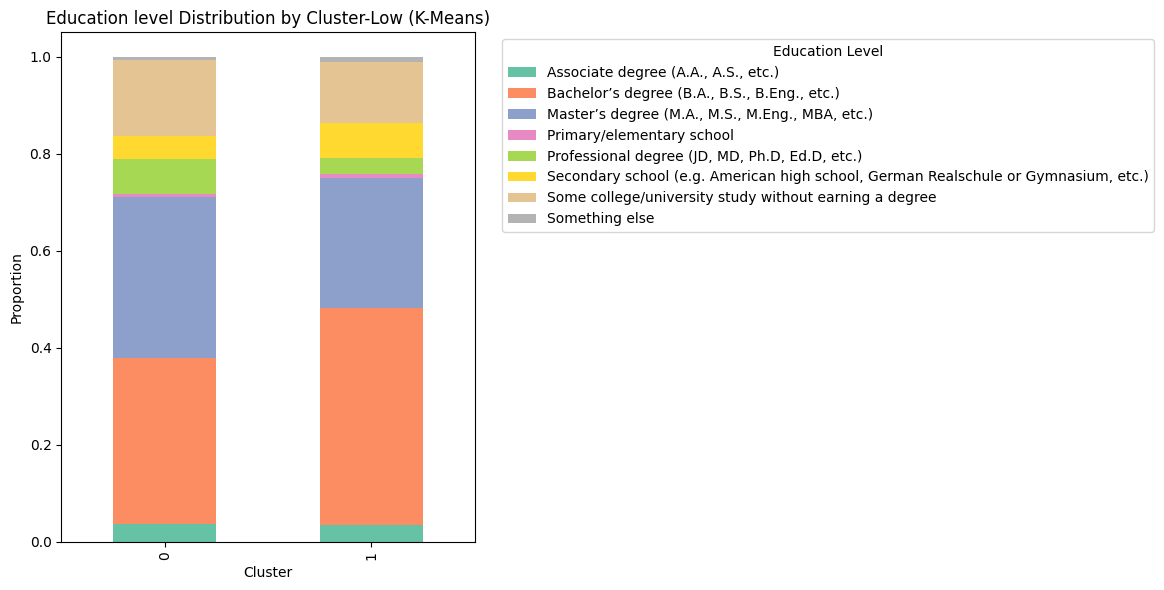

In [46]:
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
selected_data_cluster_low['KMeans_Cluster'] = kmeans.fit_predict(Q_low)

# Crosstab to calculate proportions
edu_prop = pd.crosstab(selected_data_cluster_low['KMeans_Cluster'],
                       selected_data_cluster_low['EdLevel'],normalize ='index')


# Plot
edu_prop.plot(kind='bar', stacked=True, figsize=(12, 6),colormap='Set2')

# title and labels
plt.title('Education level Distribution by Cluster-Low (K-Means)')
plt.ylabel('Proportion')
plt.xlabel('Cluster')
# Adjust legend location
plt.legend(title='Education Level',bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

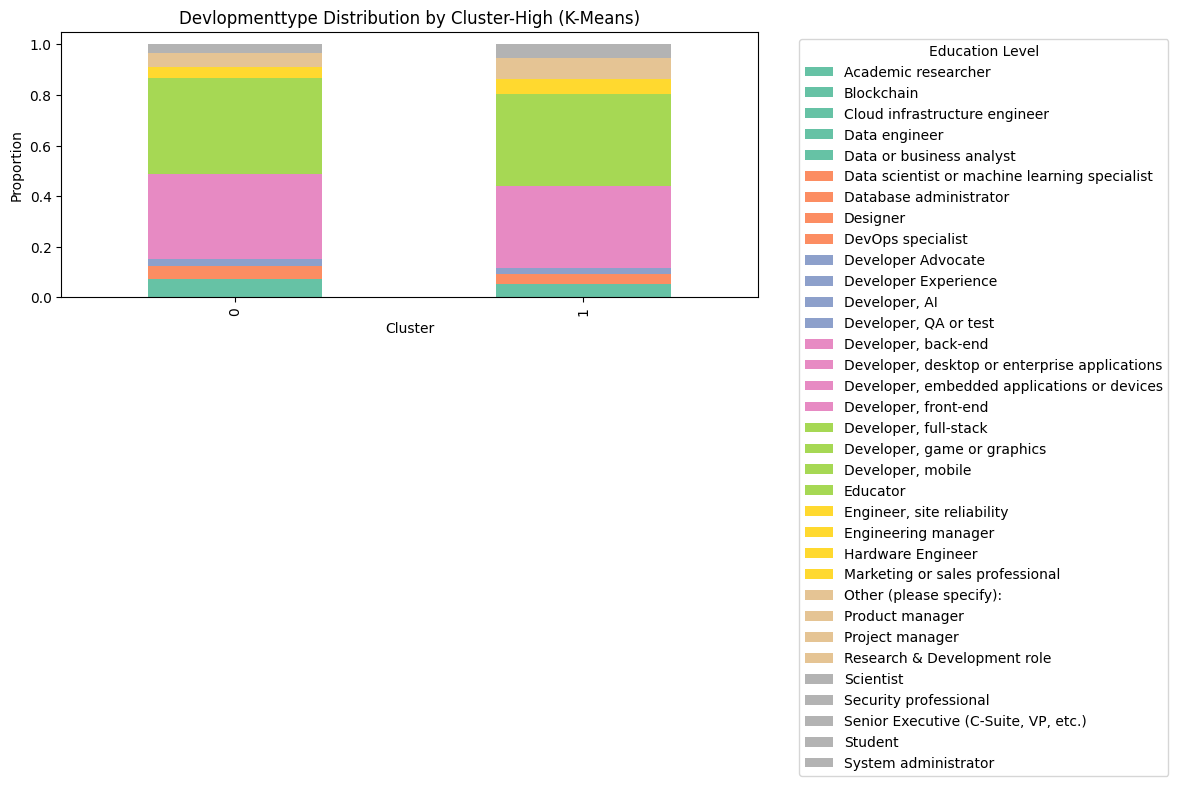

In [47]:
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
selected_data_cluster_high['KMeans_Cluster'] = kmeans.fit_predict(Q_high)

# Crosstab to calculate proportions
edu_prop = pd.crosstab(selected_data_cluster_high['KMeans_Cluster'],
                       selected_data_cluster_high['DevType'],normalize ='index')


# Plot
edu_prop.plot(kind='bar', stacked=True, figsize=(12, 6),colormap='Set2')

# title and labels
plt.title('Devlopmenttype Distribution by Cluster-High (K-Means)')
plt.ylabel('Proportion')
plt.xlabel('Cluster')
# Adjust legend location
plt.legend(title='Education Level',bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

CLUSTER ANALYSIS

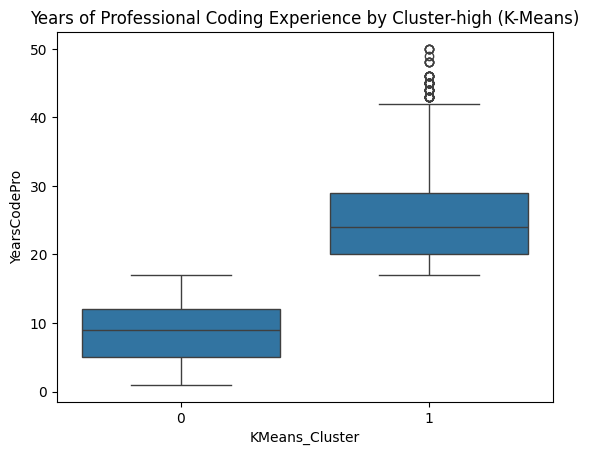

In [48]:
sns.boxplot(x='KMeans_Cluster', y='YearsCodePro', data=selected_data_cluster_high)

# display the plot
plt.title('Years of Professional Coding Experience by Cluster-high (K-Means)')
plt.show()

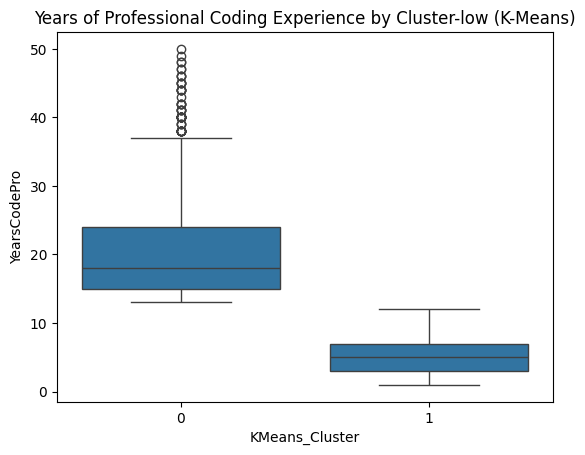

In [49]:
sns.boxplot(x='KMeans_Cluster', y='YearsCodePro', data=selected_data_cluster_low)

# display the plot
plt.title('Years of Professional Coding Experience by Cluster-low (K-Means)')
plt.show()

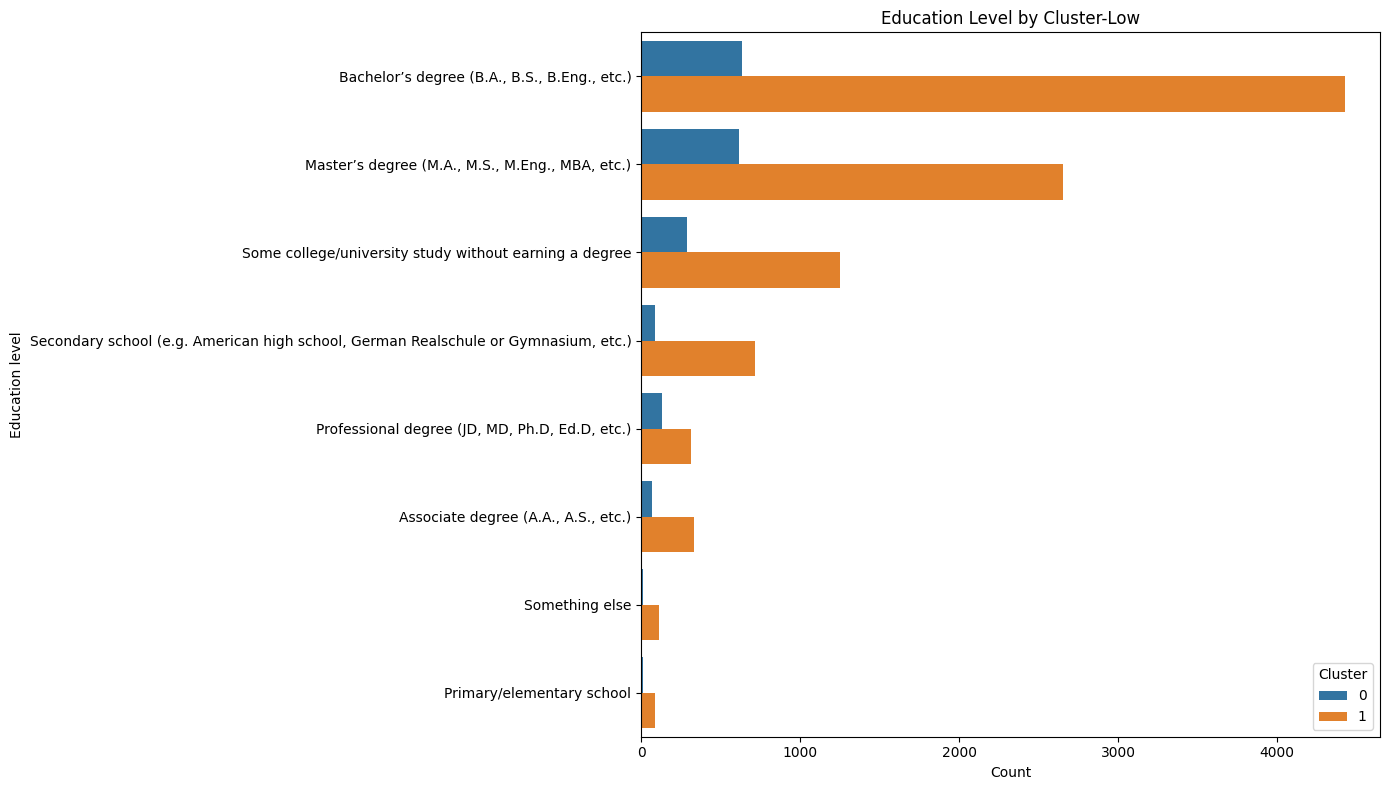

In [50]:
from sklearn.cluster import KMeans

optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
selected_data_cluster_low['Cluster'] = kmeans.fit_predict(Q_low)
#Split the 'DevType' strings into lists
selected_data_cluster_low['EdLevel_split'] = selected_data_cluster_low['EdLevel'].str.split(';')

#de the list into separate rows, one row per DevType
selected_data_exploded = selected_data_cluster_low.explode('EdLevel_split')

# Add the Cluster column to the exploded dataframe
selected_data_exploded['Cluster'] = selected_data_cluster_low['Cluster']

#Plot top 10 DevTypes by cluster
plt.figure(figsize=(14, 8))

# Filter for top 10 DevTypes and plot
sns.countplot(y='EdLevel_split', hue='Cluster',
              data=selected_data_exploded[selected_data_exploded['EdLevel_split'].isin(
                  selected_data_exploded['EdLevel_split'].value_counts().index[:10])],
              order=selected_data_exploded['EdLevel_split'].value_counts().index[:10])

# Add title and labels
plt.title('Education Level by Cluster-Low')
plt.xlabel('Count')
plt.ylabel('Education level')

# Show the plot
plt.tight_layout()
plt.show()

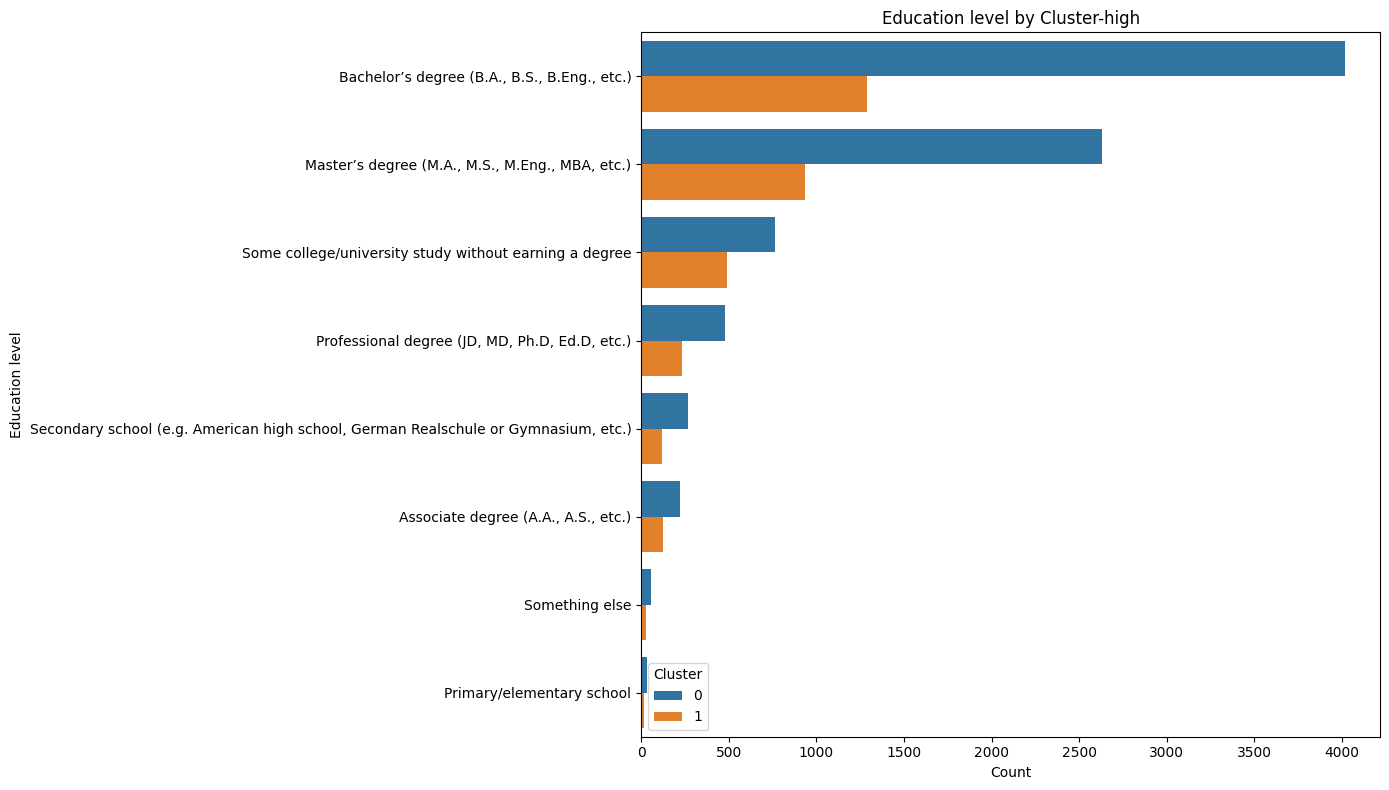

In [51]:
from sklearn.cluster import KMeans

optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
selected_data_cluster_high['Cluster'] = kmeans.fit_predict(Q_high)
#Split the 'DevType' strings into lists
selected_data_cluster_high['EdLevel_split'] = selected_data_cluster_high['EdLevel'].str.split(';')

#de the list into separate rows, one row per DevType
selected_data_exploded = selected_data_cluster_high.explode('EdLevel_split')

# Add the Cluster column to the exploded dataframe
selected_data_exploded['Cluster'] = selected_data_cluster_high['Cluster']

#Plot top 10 DevTypes by cluster
plt.figure(figsize=(14, 8))

# Filter for top 10 DevTypes and plot
sns.countplot(y='EdLevel_split', hue='Cluster',
              data=selected_data_exploded[selected_data_exploded['EdLevel_split'].isin(
                  selected_data_exploded['EdLevel_split'].value_counts().index[:10])],
              order=selected_data_exploded['EdLevel_split'].value_counts().index[:10])

# Add title and labels
plt.title('Education level by Cluster-high')
plt.xlabel('Count')
plt.ylabel('Education level')

# Show the plot
plt.tight_layout()
plt.show()

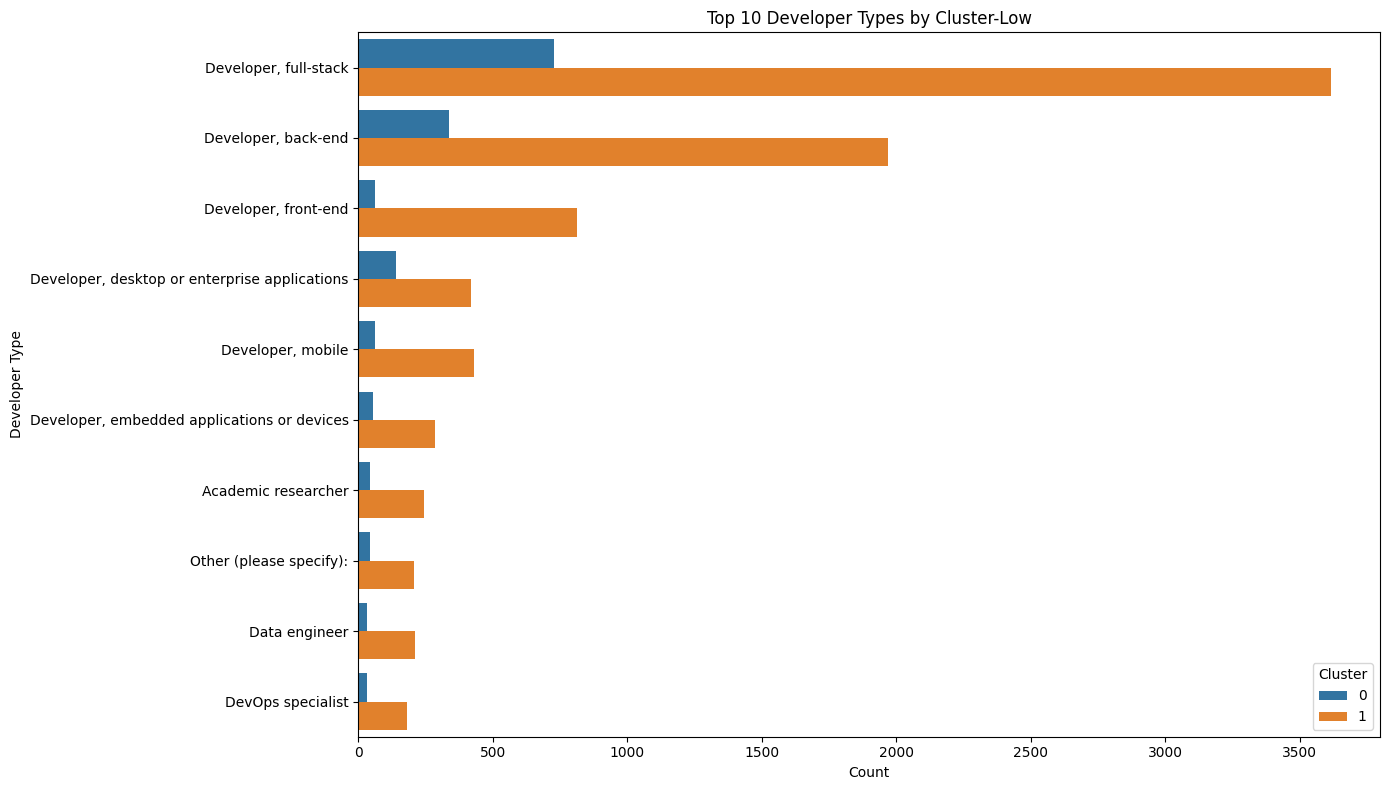

In [52]:
from sklearn.cluster import KMeans

optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
selected_data_cluster_low['Cluster'] = kmeans.fit_predict(Q_low)
#Split the 'DevType' strings into lists
selected_data_cluster_low['DevType_split'] = selected_data_cluster_low['DevType'].str.split(';')

#de the list into separate rows, one row per DevType
selected_data_exploded = selected_data_cluster_low.explode('DevType_split')

# Add the Cluster column to the exploded dataframe
selected_data_exploded['Cluster'] = selected_data_cluster_low['Cluster']

#Plot top 10 DevTypes by cluster
plt.figure(figsize=(14, 8))

# Filter for top 10 DevTypes and plot
sns.countplot(y='DevType_split', hue='Cluster',
              data=selected_data_exploded[selected_data_exploded['DevType_split'].isin(
                  selected_data_exploded['DevType_split'].value_counts().index[:10])],
              order=selected_data_exploded['DevType_split'].value_counts().index[:10])

# Add title and labels
plt.title('Top 10 Developer Types by Cluster-Low')
plt.xlabel('Count')
plt.ylabel('Developer Type')

# Show the plot
plt.tight_layout()
plt.show()

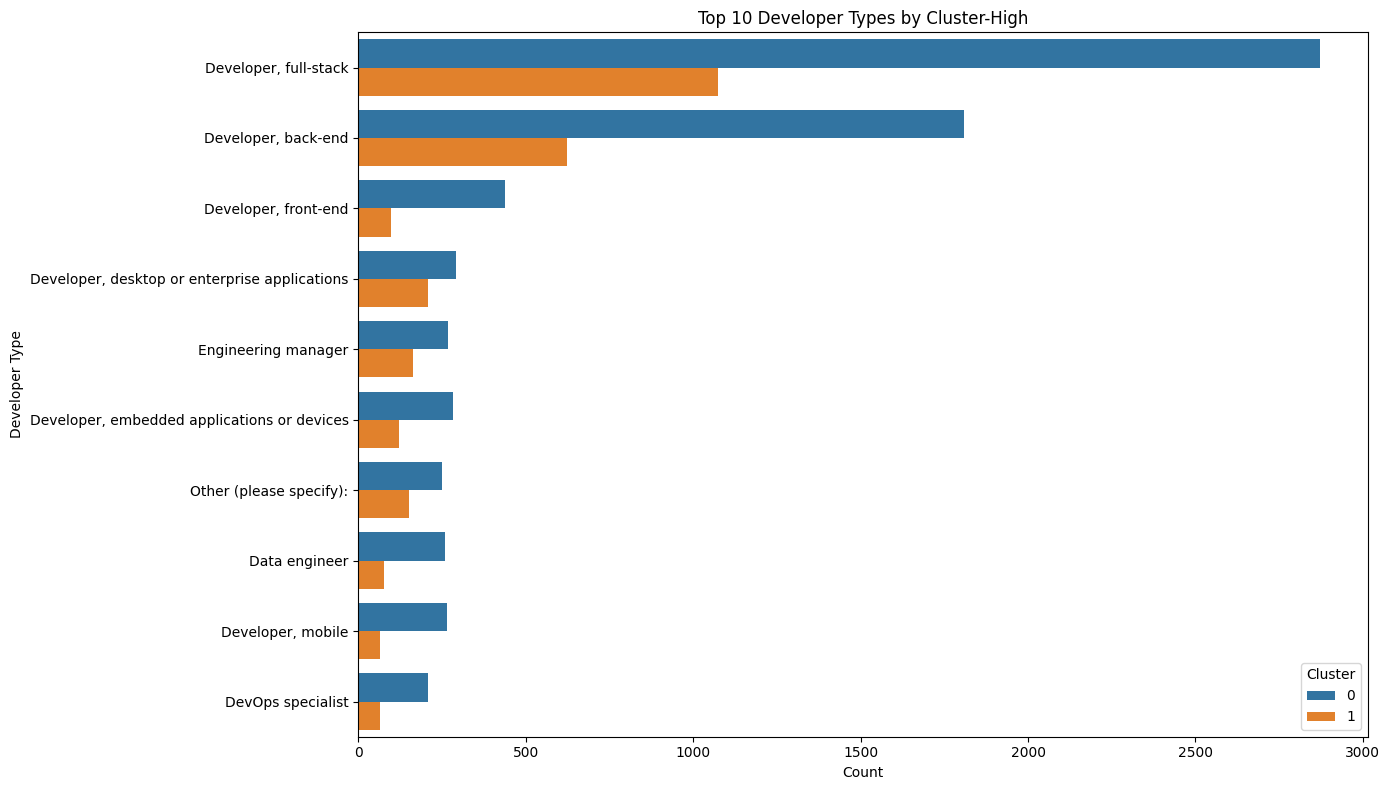

In [53]:
from sklearn.cluster import KMeans

optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
selected_data_cluster_high['Cluster'] = kmeans.fit_predict(Q_high)
#Split the 'DevType' strings into lists
selected_data_cluster_high['DevType_split'] = selected_data_cluster_high['DevType'].str.split(';')

#de the list into separate rows, one row per DevType
selected_data_exploded = selected_data_cluster_high.explode('DevType_split')

# Add the Cluster column to the exploded dataframe
selected_data_exploded['Cluster'] = selected_data_cluster_high['Cluster']

#Plot top 10 DevTypes by cluster
plt.figure(figsize=(14, 8))

# Filter for top 10 DevTypes and plot
sns.countplot(y='DevType_split', hue='Cluster',
              data=selected_data_exploded[selected_data_exploded['DevType_split'].isin(
                  selected_data_exploded['DevType_split'].value_counts().index[:10])],
              order=selected_data_exploded['DevType_split'].value_counts().index[:10])

# Add title and labels
plt.title('Top 10 Developer Types by Cluster-High')
plt.xlabel('Count')
plt.ylabel('Developer Type')

# Show the plot
plt.tight_layout()
plt.show()